In [ ]:
# import library
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py 
from matplotlib.ticker import AutoLocator
from matplotlib.ticker import MaxNLocator
tf.config.run_functions_eagerly(True)
tf.random.set_seed(1)

In [ ]:
!nvidia-smi 

Fri Jul 15 10:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load dataset

In [ ]:
# download dataset from drive
!gdown --id 1TbMAXAUicGOqh23OAbSpf3A2-Ct_yCZr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TbMAXAUicGOqh23OAbSpf3A2-Ct_yCZr
To: /content/1512427.zip
100% 880M/880M [00:09<00:00, 93.6MB/s]


In [ ]:
# unzip the dataset
!unzip '/content/1512427.zip' -d '/content/dataset'

Archive:  /content/1512427.zip
 extracting: /content/dataset/brainTumorDataPublic_1-766.zip  
 extracting: /content/dataset/brainTumorDataPublic_1533-2298.zip  
 extracting: /content/dataset/brainTumorDataPublic_767-1532.zip  
 extracting: /content/dataset/brainTumorDataPublic_2299-3064.zip  
 extracting: /content/dataset/cvind.mat  
 extracting: /content/dataset/README.txt  


In [ ]:
!unzip '/content/dataset/brainTumorDataPublic_1-766.zip' -d '/content/dataset/brainTumorDataPublic_1-766'
!unzip '/content/dataset/brainTumorDataPublic_767-1532.zip' -d '/content/dataset/brainTumorDataPublic_767-1532'
!unzip '/content/dataset/brainTumorDataPublic_1533-2298.zip' -d '/content/dataset/brainTumorDataPublic_1533-2298'
!unzip '/content/dataset/brainTumorDataPublic_2299-3064.zip' -d '/content/dataset/brainTumorDataPublic_2299-3064'

Archive:  /content/dataset/brainTumorDataPublic_1-766.zip
  inflating: /content/dataset/brainTumorDataPublic_1-766/1.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/10.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/100.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/101.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/102.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/103.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/104.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/105.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/106.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/107.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/108.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/109.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/11.mat  
  inflating: /content/dataset/brainTumorDataPublic_1-766/110.mat  
  inflat

In [ ]:
path_original_ds = '/content/drive/MyDrive/brain-tumor/dataset/save_splited_name'
print(os.path.exists(path_original_ds))

True


# Process and add generated data

## Function

In [ ]:
# load image and label from .mat file
def process_ds(file_path):
    source_file = h5py.File(file_path.numpy().decode('utf-8'), 'r')
    label_h5 = source_file.get('cjdata/label')
    label = int(np.asarray(label_h5)[0][0]) - 1
    image_h5 = source_file.get('cjdata/image')
    try:
        image = np.array(image_h5).reshape((512,512))
    except:
        image = np.array(image_h5).reshape((256,256))
    image_stacked = np.stack((image,image,image))
    image_stacked = np.moveaxis(image_stacked, 0, -1)

    return image_stacked, label

In [ ]:
# normalize and form the shape of each element
def fixed_shape(image_stacked, label):
  image_stacked.set_shape([224,224,3])
  image_stacked = tf.image.resize(image_stacked, [224, 224]) # resize original size of 512x512 to 224x224
  normalize = tf.keras.layers.Rescaling(1./127.5, offset = -1) # normalize the range of image value from [0,255] to [-1,1]
  image_stacked_tf = normalize(image_stacked)
  #image_stacked_tf = image_stacked / 127.5 - 1.0
  image_stacked_tf.set_shape([224,224,3])
  label_one_hot = tf.one_hot(int(label), depth = 3, dtype = tf.float16) # classes number = 3
  label_one_hot.set_shape([3,])
  return image_stacked_tf, label_one_hot

In [ ]:
def demonstrate_generate_data(g_model, samples, latent_dim, tumor_class):
  gen_imgs_stacked = np.zeros((samples, 224, 224, 3))
  r, c = 5, 5
  noise = np.random.normal(0,1, (samples, latent_dim))
  
  noise_labels = np.random.randint(tumor_class, tumor_class+3, (samples, 1))
  noise_labels_o = np.eye(3)[noise_labels]
  noise_labels_o = np.reshape(noise_labels_o, (samples, 3))

  gen_imgs = g_model.predict([noise, noise_labels_o])
  #gen_imgs_tf = tf.data.Dataset.from_tensor_slices(gen_imgs)
  #print(gen_imgs_tf.shape)
  #print(gen_imgs_tf.element_spec)

  for i in range(samples):
    gen_imgs_stacked[i] = np.stack((gen_imgs[i,:,:,0], gen_imgs[i,:,:,0], gen_imgs[i,:,:,0]), axis = -1)
  print(gen_imgs_stacked.shape)
  gen_imgs = gen_imgs * 127.5 + 127.5
  fig = plt.figure(figsize= (16,8))
  cnt = 0
  for i in range(r*c):
    ax = plt.subplot(r,c,i+1)
    ax.imshow(gen_imgs[i,:,:,0],'gray')
    ax.set_title(noise_labels_o[i])
    ax.axis('off')
  plt.show()
  

In [ ]:
def generate_data(g_model, samples, latent_dim, tumor_class):
  gen_imgs_stacked = np.zeros((samples, 224, 224, 3))
  noise = np.random.normal(0,1, (samples, latent_dim))
  
  noise_labels = np.random.randint(tumor_class, tumor_class+1, (samples, 1))
  noise_labels_o = np.eye(3)[noise_labels]
  noise_labels_o = np.reshape(noise_labels_o, (samples, 3))
  noise_labels_o = tf.convert_to_tensor(noise_labels_o, dtype = tf.float16)

  gen_imgs = g_model.predict([noise, noise_labels_o])

  for i in range(samples):
    gen_imgs_stacked[i] = np.stack((gen_imgs[i,:,:,0], gen_imgs[i,:,:,0], gen_imgs[i,:,:,0]), axis = -1)

  gen_imgs_tf = tf.convert_to_tensor(gen_imgs_stacked, dtype = tf.float32)
  gen_imgs_tf = tf.data.Dataset.from_tensor_slices(gen_imgs_tf)
  noise_labels_o = tf.data.Dataset.from_tensor_slices(noise_labels_o)
  return tf.data.Dataset.zip((gen_imgs_tf, noise_labels_o))

In [ ]:
# shuffle dataset and divide it into batches 
def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 1024)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    return ds

In [ ]:
def gan_dataset(g_model, samples, latent_dim):
  gan_ds_0 = generate_data(gen_model, samples, latent_dim,0)
  gan_ds_1 = generate_data(gen_model, samples, latent_dim,1)
  gan_ds_2 = generate_data(gen_model, samples, latent_dim,2)
  gan_ds = gan_ds_0.concatenate(gan_ds_1)
  gan_ds = gan_ds.concatenate(gan_ds_2)
  return gan_ds

## Run

In [ ]:
train_ds = tf.data.experimental.load(os.path.join(path_original_ds, 'train'))
test_ds = tf.data.experimental.load(os.path.join(path_original_ds, 'test'))
val_ds = tf.data.experimental.load(os.path.join(path_original_ds, 'val'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# mapping dataset
train_ds = train_ds.map(lambda x: tf.py_function(process_ds, [x], [tf.float32, tf.float16]))
train_ds = train_ds.map(fixed_shape)
val_ds = val_ds.map(lambda x: tf.py_function(process_ds, [x], [tf.float32, tf.float16]))
val_ds = val_ds.map(fixed_shape)
test_ds = test_ds.map(lambda x: tf.py_function(process_ds, [x], [tf.float32, tf.float16]))
test_ds = test_ds.map(fixed_shape)
# check element spec
train_ds.element_spec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(3,), dtype=tf.float16, name=None))

In [ ]:
# load ac-gan model
gen_json_path = '/content/drive/MyDrive/brain-tumor/GAN/AC-GAN/1/generator_480.json'
gen_weights_path = '/content/drive/MyDrive/brain-tumor/GAN/AC-GAN/1/generator_weights_480.hdf5'
gen_json = open(gen_json_path, 'r')
gen_model = gen_json.read()
gen_json.close()
gen_model = tf.keras.models.model_from_json(gen_model)
gen_model.summary()

In [ ]:
gen_model.load_weights(gen_weights_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(25, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


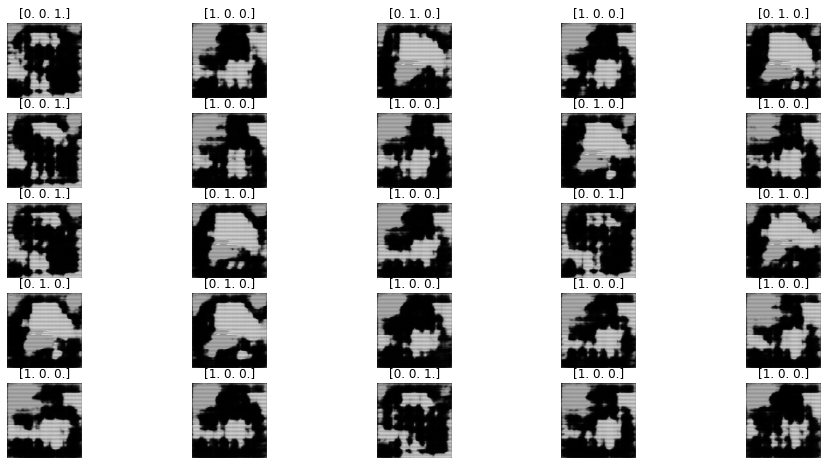

In [ ]:
demonstrate_generate_data(gen_model, 25, 100, 0)

In [ ]:
# generate images
samples = 300
latent_dim = 100
gan_ds = gan_dataset(gen_model, samples = samples, latent_dim = latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
gan_ds.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(3,), dtype=tf.float16, name=None))

In [ ]:
gan_ds.cardinality().numpy()

900

In [ ]:
train_ds.cardinality().numpy()

306

In [ ]:
train_gan_ds = train_ds.concatenate(gan_ds)
train_gan_ds.cardinality().numpy()

1206

In [ ]:
train_gan_ds.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(3,), dtype=tf.float16, name=None))

In [ ]:
# divide dataset into batches and load to cache
val_ds = configure_for_performance(val_ds, batch_size = 16)
test_ds = configure_for_performance(test_ds, batch_size = 16)
train_gan_ds = configure_for_performance(train_gan_ds, batch_size = 16)
train_ds = configure_for_performance(train_ds, batch_size = 16)

# Training function

In [ ]:
def training_process(model, train_ds, val_ds, initial_epochs, total_epochs, checkpoint_path):
    #history_path = os.path.join(history_dirs, '{start}-{end}'.format(start = initial_epochs, end = total_epochs))
    #os.mkdir(history_path)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        save_weights_only = True,
        monitor = 'val_accuracy', 
        verbose = 1,
        mode = 'max',
        save_best_only = True)
    history = model.fit(
    train_ds,
    validation_data = val_ds,
    initial_epoch = initial_epochs,
    epochs = total_epochs,
    callbacks = [model_checkpoint_callback])
    return history

In [ ]:
def save_history_file(history, history_path, start_epoch, end_epoch, note = 'training'):
  path = os.path.join(history_path, '{note}_history_{start_epoch}-{end_epoch}'.format(note = note, start_epoch = start_epoch, end_epoch = end_epoch))
  np.save(path, history.history)
  return 

In [ ]:
def save_history_plot(history, history_path, start_epoch, end_epoch, note = 'training'):
  plt.figure(figsize = (16,8))
  for i in range(2):
    ax = plt.subplot(1, 2, i + 1)    
    if i < 1:
      plt.plot(history.history['accuracy'], label = 'train_acc')
      plt.plot(history.history['val_accuracy'], label = 'val_acc')
      #plt.xticks(np.arange(start_epoch, end_epoch, 10))
      plt.xlabel('epoch')
      plt.ylabel('Accuracy')
      plt.legend()
    else:
      plt.plot(history.history['loss'], label = 'train_loss')
      plt.plot(history.history['val_loss'], label = 'val_loss')
      #plt.xticks(np.arange(start_epoch, end_epoch, 10))
      plt.xlabel('epoch')
      plt.ylabel('Loss')
      plt.legend()
  plt.savefig(os.path.join(history_path, '{note}_history_{start_epoch}-{end_epoch}.pdf'.format(note = note, start_epoch = start_epoch, end_epoch = end_epoch)))
  return 

# VGG16

## Settings

In [ ]:
# load pretrained model
vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_tensor = tf.keras.layers.Input(shape = (224,224,3)),
    input_shape = (224,224,3))
vgg16_base.trainable = False # freeze CNN

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# build transfer learning model
inputs = tf.keras.Input(shape = (224,224,3))
x = vgg16_base(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3)(x)
outputs = tf.keras.layers.Softmax()(x)
model_vgg16_4 = tf.keras.Model(inputs, outputs)
model_vgg16_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656

In [ ]:
# complie model
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy()
model_vgg16_4.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy'])

### Training on original dataset

In [ ]:
checkpoint_path_vgg = '/content/drive/MyDrive/brain-tumor/result/vgg16-4/checkpoint/3_vgg16_4_weights.hdf5'
history_dirs = '/content/drive/MyDrive/brain-tumor/result/vgg16-4/history'
print(os.path.exists(checkpoint_path_vgg))
print(os.path.exists(history_dirs))

False
True


In [ ]:
history = training_process(model_vgg16_4, train_ds, val_ds, 0, 100, checkpoint_path_vgg)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9477
Epoch 1: val_accuracy improved from -inf to 0.84314, saving model to /content/drive/MyDrive/brain-tumor/result/vgg16-4/checkpoint/3_vgg16_4_weights.hdf5
20/20 [==============================] - 5s 242ms/step - loss: 0.1471 - accuracy: 0.9477 - val_loss: 0.4454 - val_accuracy: 0.8431
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9510
Epoch 2: val_accuracy improved from 0.84314 to 0.86275, saving model to /content/drive/MyDrive/brain-tumor/result/vgg16-4/checkpoint/3_vgg16_4_weights.hdf5
20/20 [==============================] - 5s 230ms/step - loss: 0.1810 - accuracy: 0.9510 - val_loss: 0.4447 - val_accuracy: 0.8627
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.1228 - accuracy: 0.9671
Epoch 3: val_accuracy did not improve from 0.86275
20/20 [==============================] - 4s 218ms/step - loss: 0.1270 - accuracy: 0.9641 - va

In [ ]:
model_vgg16_4.load_weights(checkpoint_path_vgg)

In [ ]:
model_vgg16_4.evaluate(test_ds)

154/154 [==============================] - 9s 60ms/step - loss: 0.3552 - accuracy: 0.8813


[0.35521653294563293, 0.881321370601654]

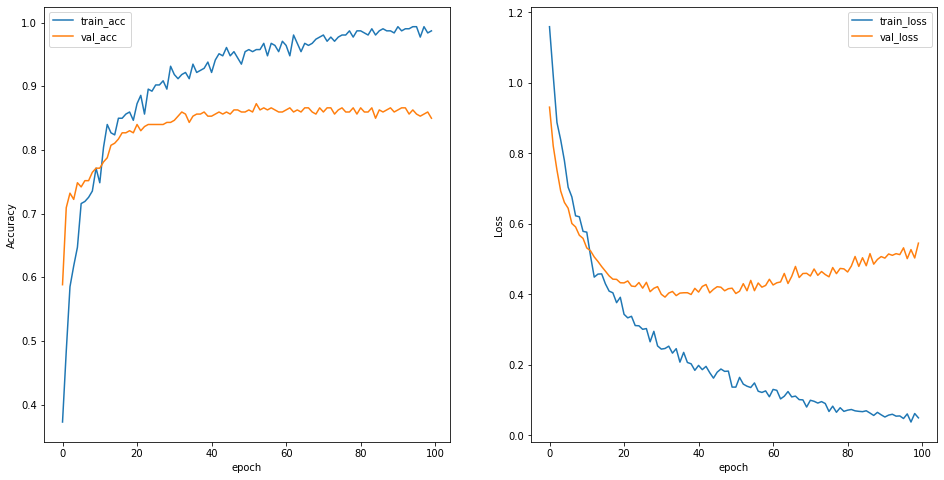

In [ ]:
save_history_file(history, history_dirs, 0, 100)
save_history_plot(history, history_dirs, 0, 100)

### Fine-tuning on additional dataset

In [ ]:
checkpoint_path = '/content/drive/MyDrive/brain-tumor/result/vgg16-4-acgan/checkpoint/scratch_900_acgan_vgg16_4_weights.hdf5'
history_gan_dirs = '/content/drive/MyDrive/brain-tumor/result/vgg16-4-acgan/history'
print(os.path.exists(checkpoint_path))
print(os.path.exists(history_dirs))

False
True


In [ ]:
history = training_process(model_vgg16_4, train_gan_ds, val_ds, 0, 100, checkpoint_path)

Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.4171
Epoch 1: val_accuracy improved from -inf to 0.68954, saving model to /content/drive/MyDrive/brain-tumor/result/vgg16-4-acgan/checkpoint/scratch_900_acgan_vgg16_4_weights.hdf5
76/76 [==============================] - 19s 218ms/step - loss: 1.0915 - accuracy: 0.4171 - val_loss: 0.7932 - val_accuracy: 0.6895
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.9608 - accuracy: 0.5158
Epoch 2: val_accuracy improved from 0.68954 to 0.70588, saving model to /content/drive/MyDrive/brain-tumor/result/vgg16-4-acgan/checkpoint/scratch_900_acgan_vgg16_4_weights.hdf5
76/76 [==============================] - 14s 188ms/step - loss: 0.9608 - accuracy: 0.5158 - val_loss: 0.7101 - val_accuracy: 0.7059
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.6352
Epoch 3: val_accuracy improved from 0.70588 to 0.76471, saving model to /content/drive/MyDrive/bra

In [ ]:
model_vgg16_4.load_weights(checkpoint_path)

In [ ]:
model_vgg16_4.evaluate(test_ds)

154/154 [==============================] - 10s 63ms/step - loss: 0.4078 - accuracy: 0.8638


[0.4077893793582916, 0.863784670829773]

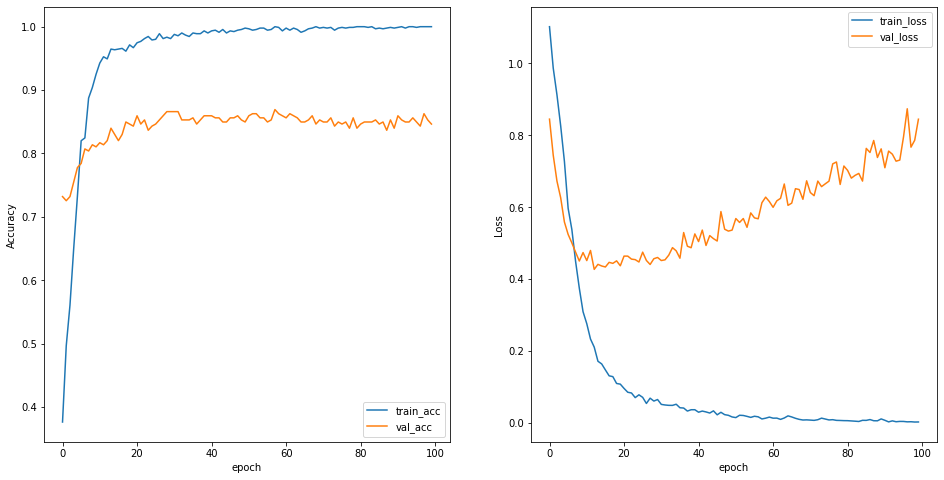

In [ ]:
save_history_file(history, history_dirs, 0, 100, 'scratch_600')
save_history_plot(history, history_dirs, 0, 100, 'scratch_600')

# Inception v3

## Settings 

In [ ]:
# load pretrained model
inceptionv3_base = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_tensor = tf.keras.layers.Input(shape = (224,224,3)),
    input_shape = (224,224,3))
inceptionv3_base.trainable = False # freeze CNN

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# build transfer learning model
inputs = tf.keras.Input(shape = (224,224,3))
x = inceptionv3_base(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3)(x)
outputs = tf.keras.layers.Softmax()(x)
inceptionv3_1 = tf.keras.Model(inputs, outputs)
inceptionv3_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_97 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049

In [ ]:
# complie model
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy()
inceptionv3_1.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy'])

## Training on original dataset

In [ ]:
checkpoint_path_inception = '/content/drive/MyDrive/brain-tumor/result/inceptionv3-1/checkpoint/inceptionv3-1_weights.hdf5'
history_dirs_inception = '/content/drive/MyDrive/brain-tumor/result/inceptionv3-1/history'

In [ ]:
history = training_process(inceptionv3_1, train_ds, val_ds, 0, 100, checkpoint_path_inception)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.5229
Epoch 1: val_accuracy improved from -inf to 0.60784, saving model to /content/drive/MyDrive/brain-tumor/result/inceptionv3-1/checkpoint/inceptionv3-1_weights.hdf5
20/20 [==============================] - 13s 428ms/step - loss: 1.0316 - accuracy: 0.5229 - val_loss: 0.8295 - val_accuracy: 0.6078
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.6013
Epoch 2: val_accuracy improved from 0.60784 to 0.62092, saving model to /content/drive/MyDrive/brain-tumor/result/inceptionv3-1/checkpoint/inceptionv3-1_weights.hdf5
20/20 [==============================] - 9s 436ms/step - loss: 0.8895 - accuracy: 0.6013 - val_loss: 0.8053 - val_accuracy: 0.6209
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.8145 - accuracy: 0.6307
Epoch 3: val_accuracy improved from 0.62092 to 0.64052, saving model to /content/drive/MyDrive/brain-tumor/result/inception

In [ ]:
inceptionv3_1.load_weights(checkpoint_path_inception)

In [ ]:
inceptionv3_1.evaluate(val_ds)

20/20 [==============================] - 4s 196ms/step - loss: 0.8198 - accuracy: 0.7778


[0.8198386430740356, 0.7777777910232544]

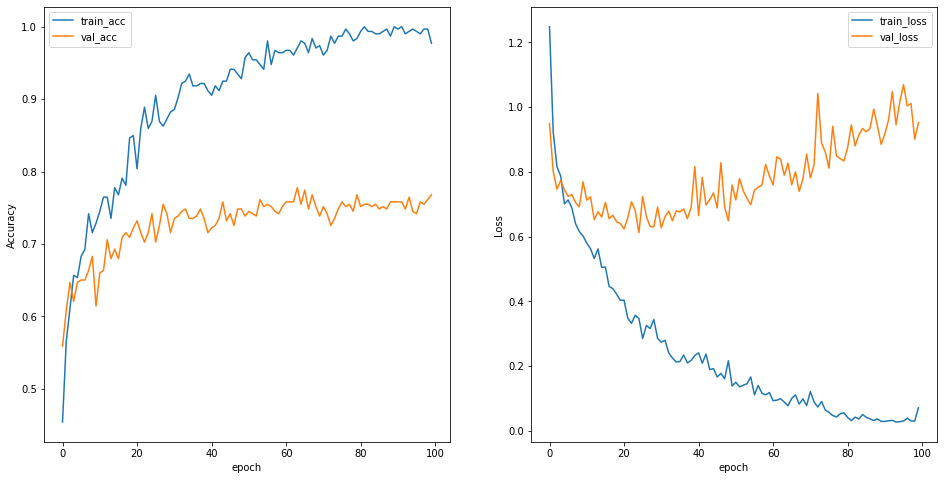

In [ ]:
save_history_file(history, history_dirs_inception, 0, 100)
save_history_plot(history, history_dirs_inception, 0, 100)

## Fine-tuning on additional dataset 

In [ ]:
checkpoint_path_acgan_incep = '/content/drive/MyDrive/brain-tumor/result/inceptionv3-1/ac-gan/checkpoint/inceptionv3_acgan_weights.hdf5'
history_acgan_incep = '/content/drive/MyDrive/brain-tumor/result/inceptionv3-1/ac-gan/history'

In [ ]:
history = training_process(inceptionv3_1, train_gan_ds, val_ds, 100, 200, checkpoint_path_acgan_incep)

Epoch 101/200
132/132 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.9074
Epoch 101: val_accuracy improved from -inf to 0.69608, saving model to /content/drive/MyDrive/brain-tumor/result/inceptionv3-1/ac-gan/checkpoint/inceptionv3_acgan_weights.hdf5
132/132 [==============================] - 34s 256ms/step - loss: 0.3321 - accuracy: 0.9074 - val_loss: 0.9027 - val_accuracy: 0.6961
Epoch 102/200
132/132 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9872
Epoch 102: val_accuracy improved from 0.69608 to 0.74183, saving model to /content/drive/MyDrive/brain-tumor/result/inceptionv3-1/ac-gan/checkpoint/inceptionv3_acgan_weights.hdf5
132/132 [==============================] - 33s 253ms/step - loss: 0.0477 - accuracy: 0.9872 - val_loss: 0.7442 - val_accuracy: 0.7418
Epoch 103/200
132/132 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9938
Epoch 103: val_accuracy did not improve from 0.74183
132/132 [==================

In [ ]:
inceptionv3_1.load_weights(checkpoint_path_acgan_incep)

In [ ]:
inceptionv3_1.evaluate(val_ds)

20/20 [==============================] - 5s 221ms/step - loss: 1.2430 - accuracy: 0.7941


[1.2430342435836792, 0.7941176295280457]

# MobileNet

## Settings

In [ ]:
# load pretrained model
mobilenet_base = tf.keras.applications.mobilenet.MobileNet(
    include_top = False,
    weights = 'imagenet',
    input_tensor = tf.keras.layers.Input(shape = (224,224,3)),
    input_shape = (224,224,3))
mobilenet_base.trainable = False # freeze CNN

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
# build transfer learning model
inputs = tf.keras.Input(shape = (224,224,3))
x = mobilenet_base(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256)(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x, training = False)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3)(x)
outputs = tf.keras.layers.Softmax()(x)
mobilenet_1 = tf.keras.Model(inputs, outputs)
mobilenet_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1024)              0         
                                                             

In [ ]:
# complie model
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy()
mobilenet_1.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy'])

## Training on original dataset

In [ ]:
checkpoint_path_mobile = '/content/drive/MyDrive/brain-tumor/result/mobilenet-1/checkpoint/mobilenet_weights.hdf5'
history_dirs_mobile = '/content/drive/MyDrive/brain-tumor/result/mobilenet-1/history'

In [ ]:
history = training_process(mobilenet_1, train_ds, val_ds, 0, 100, checkpoint_path_mobile)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.3954
Epoch 1: val_accuracy improved from -inf to 0.63072, saving model to /content/drive/MyDrive/brain-tumor/result/mobilenet-1/checkpoint/mobilenet_weights.hdf5
20/20 [==============================] - 13s 415ms/step - loss: 1.4010 - accuracy: 0.3954 - val_loss: 0.8443 - val_accuracy: 0.6307
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.9706 - accuracy: 0.5033
Epoch 2: val_accuracy improved from 0.63072 to 0.68627, saving model to /content/drive/MyDrive/brain-tumor/result/mobilenet-1/checkpoint/mobilenet_weights.hdf5
20/20 [==============================] - 3s 156ms/step - loss: 0.9706 - accuracy: 0.5033 - val_loss: 0.7529 - val_accuracy: 0.6863
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.8190 - accuracy: 0.6601
Epoch 3: val_accuracy improved from 0.68627 to 0.69935, saving model to /content/drive/MyDrive/brain-tumor/result/mobilenet-1/checkpoin

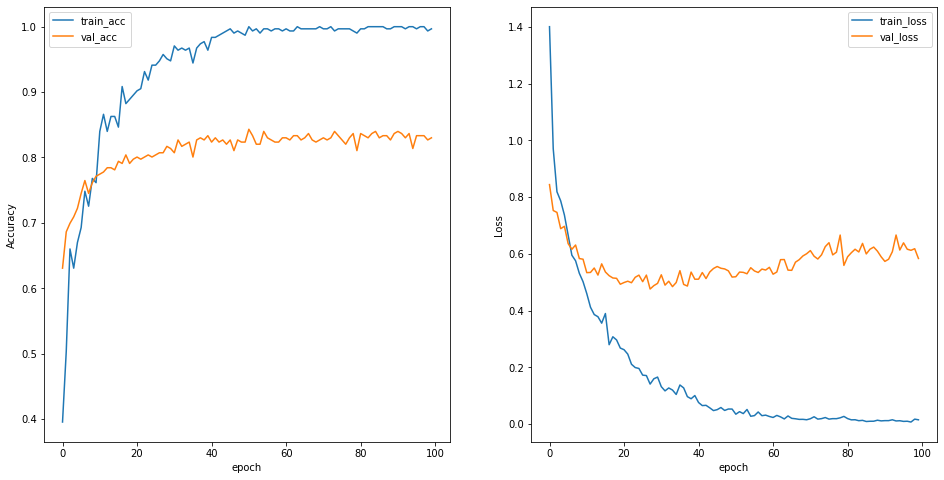

In [ ]:
save_history_file(history, history_dirs_mobile, 0, 100)
save_history_plot(history, history_dirs_mobile, 0, 100)

In [ ]:
mobilenet_1.load_weights(checkpoint_path_mobile)


In [ ]:
mobilenet_1.evaluate(val_ds)

20/20 [==============================] - 5s 49ms/step - loss: 0.5195 - accuracy: 0.8431


[0.5194817185401917, 0.843137264251709]

## Fine-tuning on additional dataset

In [ ]:
checkpoint_path_mobile_acgan = '/content/drive/MyDrive/brain-tumor/result/mobilenet-1/ac-gan/checkpoint/600_ac_gan_mobilenet_weights.hdf5'
history_dirs_mobile_acgan = '/content/drive/MyDrive/brain-tumor/result/mobilenet-1/ac-gan/history'

In [ ]:
history = training_process(mobilenet_1, train_gan_ds, val_ds, 100, 200, checkpoint_path_mobile_acgan)

Epoch 101/200
132/132 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9406
Epoch 101: val_accuracy improved from -inf to 0.81699, saving model to /content/drive/MyDrive/brain-tumor/result/mobilenet-1/ac-gan/checkpoint/600_ac_gan_mobilenet_weights.hdf5
132/132 [==============================] - 17s 104ms/step - loss: 0.1783 - accuracy: 0.9406 - val_loss: 0.5496 - val_accuracy: 0.8170
Epoch 102/200
132/132 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9905
Epoch 102: val_accuracy improved from 0.81699 to 0.83007, saving model to /content/drive/MyDrive/brain-tumor/result/mobilenet-1/ac-gan/checkpoint/600_ac_gan_mobilenet_weights.hdf5
132/132 [==============================] - 14s 109ms/step - loss: 0.0323 - accuracy: 0.9905 - val_loss: 0.5842 - val_accuracy: 0.8301
Epoch 103/200
132/132 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9934
Epoch 103: val_accuracy improved from 0.83007 to 0.84314, saving model to /con

In [ ]:
mobilenet_1.load_weights(checkpoint_path_mobile_acgan)


In [ ]:
mobilenet_1.evaluate(test_ds)

154/154 [==============================] - 8s 54ms/step - loss: 0.7472 - accuracy: 0.8507


[0.7472173571586609, 0.8507341146469116]

# Demo

## AC-GAN

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(25, 224, 224, 3)


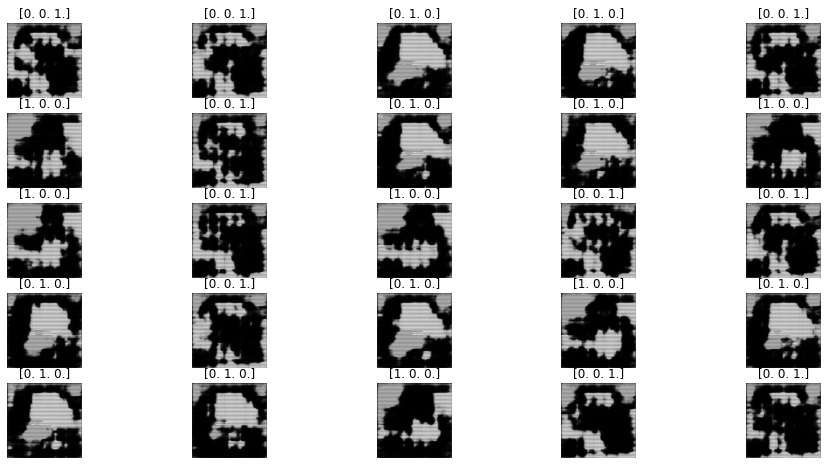

In [ ]:
demonstrate_generate_data(gen_model, 25, 100, 0)

## VGG-16

In [ ]:
path_demo_weights = '/content/drive/MyDrive/brain-tumor/result/vgg16-4-acgan/checkpoint/fine_tuning_600_acgan_vgg16_4_weights.hdf5'

In [ ]:
model_vgg16_4.load_weights(path_demo_weights)

In [ ]:
def demo_model(x, y, model):
  batch_size = x.shape[0]
  row = int(batch_size / 4)
  predicts = model.predict(x)
  x = x.numpy()
  figure = plt.figure(figsize = (15,15))
  for i in range(batch_size):
    ax = plt.subplot(row, 4, i+1)
    ax.imshow(x[i,:,:,0] * 0.5 + 0.5 , 'gray')
    ax.set_title('Ground Truth: ' + str(y[i].numpy()) + '\nPredicts: ' + str(np.round(predicts, decimals = 2)[i]))
    ax.set_axis_off()
  plt.show()
  


  


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


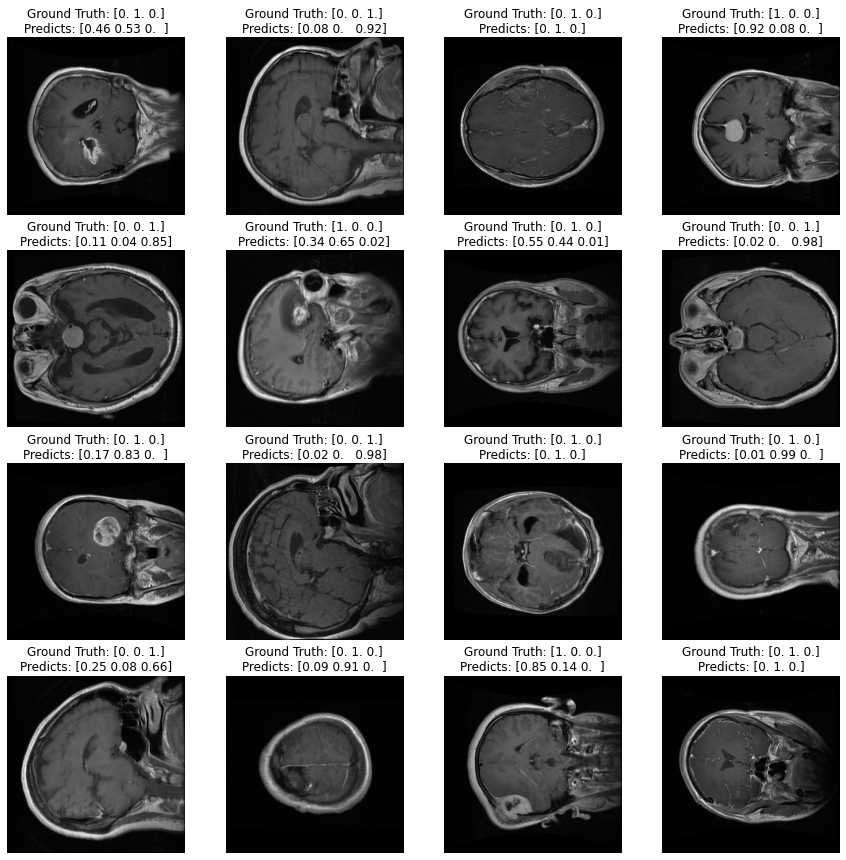

In [ ]:
for x,y in test_ds:
  #print(np.max(x.numpy()))
  demo_model(x,y, model_vgg16_4)
  break